# Adaptive PDE discretizations on cartesian grids 
## Volume : Reproducible research
## Part : Eikonal CPU/GPU solvers comparison
## Chapter : Manifolds defined by local charts

We solve eikonal PDEs on manifolds defined by local charts. In particular the projective plane, and the klein bottle.

This functionality is so far only implemented in the GPU eikonal solver. It is used in the context of the rolling ball models, which involve PDEs on the group $\mathrm{SO}_3$, parametrized by three dimensional projective space $\mathrm{P}_3$.

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"../..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Trailers','GPU'))

In [2]:
from agd import Eikonal
from agd import AutomaticDifferentiation as ad
from agd import FiniteDifferences as fd
from agd import Metrics
from agd import LinearParallel as lp
norm = ad.Optimization.norm

In [3]:
from agd.ExportedCode.Notebooks_Algo import RollingBall_Models
plane_to_sphere = RollingBall_Models.quaternion_from_euclidean
sphere_to_plane = RollingBall_Models.euclidean_from_quaternion

In [4]:
import numpy as np; xp=np; allclose = np.allclose
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

### 0.1 Additional configuration

The GPU accelerated solver is mandatory for this notebook.

In [5]:
xp,Eikonal,plt,allclose = [ad.cupy_friendly(e) for e in (xp,Eikonal,plt,allclose)]

Replacing numpy with cupy, set to output 32bit ints and floats by default.
Using cp.asarray(*,dtype=np.float32) as the default caster in ad.array.
Setting dictIn.default_mode = 'gpu' in module agd.Eikonal .
Returning a copy of module matplotlib.pyplot whose functions accept cupy arrays as input.
Setting float32 compatible default values atol=rtol=1e-5 in np.allclose


## 1. Projective plane



### 1.1 Manifold description

The projective plane is defined as the unit sphere, in which pairs of opposite points are identified.
The `plane_to_sphere` map parametrizes the northern hemisphere from the equatorial disk, by projection from the south pole.

In [6]:
def chart_mapping(x): 
    """
    Glue map for the projective plane, as parameterized from the equator.
    (Maps a point to the other point with which it identifies.)
    """    
    return sphere_to_plane( - plane_to_sphere(x))

The equatorial projection is conformal to the isotropic metric on the plane, with an explicit cost function.

In [7]:
def metric(x):
    """
    Pulls back the Euclidean metric on the sphere onto the plane.
    """
    x_ad = ad.Dense.identity(constant=x,shape_free=(len(x),))
    Jac = np.moveaxis(plane_to_sphere(x_ad).gradient(),0,1)
    return lp.dot_AA(lp.transpose(Jac),Jac)

def cost(x):
    """
    Cost function associated with the conformal metric of the stereographic projection.
    """
    return np.sqrt(metric(x)[0,0]) # Alternatively, use the explicit expression 2/sqrt(1+ |x|^2)

In [8]:
def cost(x):
    """
    Isotropic cost function for the projective plane, as parametrized from the equator.
    """
    return 2/(1.+lp.dot_VV(x,x))

### 1.2 Running the HFM library

We use a square, strictly containing the equatorial unit ball, as parametrization domain.

In [17]:
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seed':[0.5,0.7],
    'exportValues':True,
    'factoringRadius':10,
})

r=1.1
hfmIn.SetRect([[-r,r],[-r,r]],dimx=2001)
X = hfmIn.Grid()

hfmIn['cost']=cost(X)
hfmIn.SetUniformTips((4,4))

Next we need to describe the local charts.

In [18]:
hfmIn['chart_mapping'] = chart_mapping(X) # mapping to opposite point
hfmIn['chart_jump'] = norm(X,axis=0) > (1+r)/2 # When geodesics should jump
#hfmIn['chart_nitermax'] = 1

In [19]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.6799747943878174 seconds, and 431 iterations.
Post-Processing


The computed distance values are minimal at the seed, and at the opposite point. 

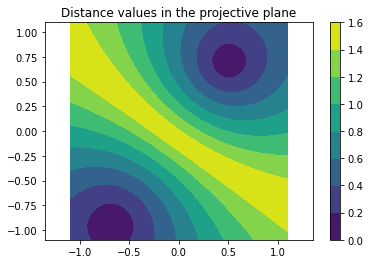

In [20]:
plt.title("Distance values in the projective plane")
plt.contourf(*X,hfmOut['values'])
plt.axis('equal'); plt.colorbar();

The geodesics jump to according to the local chart as prescribed.

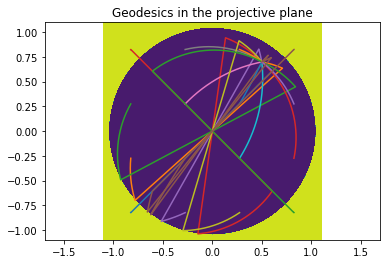

In [21]:
plt.title("Geodesics in the projective plane")
plt.axis('equal')
plt.contourf(*X,hfmIn['chart_jump'])
for geo in hfmOut['geodesics']: plt.plot(*geo)

### 1.3 Comparison with exact solutions.

The geodesics and geodesic distances on the sphere are known, and correspond to paths along the great circles.
The situation is similar on the projective plane, except closed geodesics are only half circles.

In [22]:
def spherical_distance(p,q):
    """Distance on the sphere, betweeen two points of the sphere"""
    p,q = fd.common_field((p,q),depths=(1,1))
    return 2*np.arcsin(norm(p-q,axis=0)/2)

In [23]:
seed_S = plane_to_sphere(hfmIn['seed'])
X_S = plane_to_sphere(X)
exact = np.minimum(spherical_distance(seed_S,X_S),spherical_distance(-seed_S,X_S))

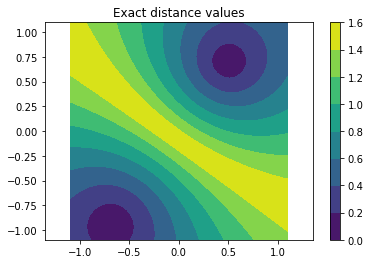

In [25]:
plt.title('Exact distance values')
plt.contourf(*X,exact)
plt.colorbar(); plt.axis('equal');

The values are quite close. The biggest discrepancy is in the center of the domain, where the metric is stronger. In particular, it is unrelated with the chart mapping.

In [37]:
assert norm(exact-hfmOut['values'],ord=np.inf) < 0.02

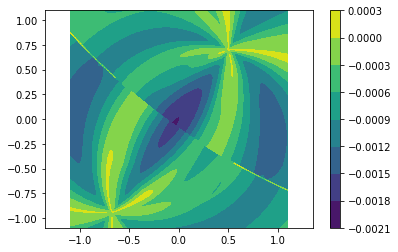

In [26]:
plt.contourf(*X,exact-hfmOut['values'])
plt.colorbar(); plt.axis('equal');

### 1.4 Variants in the computation

Multi-precision is supported. Note that it is only interesting in very large test cases.

In [27]:
hfmIn['multiprecision']=True
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.7979991436004639 seconds, and 337 iterations.
Post-Processing


In [28]:
assert norm(exact-hfmOut['values'],ord=np.inf) < 0.02
hfmIn.pop('multiprecision',None);

One may want to apply the boundary conditions only in a narrow band.

In [29]:
radius = norm(X,axis=0)
narrow_band = np.logical_and(0.9<=radius,radius<=1.1)
hfmIn['chart_mapping'] = np.where(narrow_band,chart_mapping(X),np.nan)
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.5569620132446289 seconds, and 328 iterations.
Post-Processing


Numerical error remains untouched within the fundamental domain, although larger errors are produced elsewhere.

In [30]:
assert norm(np.where(norm(X,axis=0)<1,hfmOut['values']-exact,0),ord=np.inf) < 0.02 # Same error in fundamental domain
norm(hfmOut['values']-exact,ord=np.inf) # Larger error outside

array(0.117, dtype=float32)

### 2. The sphere



### 2.1 Manifold description

The sphere can be described using two local charts

In [31]:
def chart_mapping(x):
    x=x.copy()
    s = np.sign(x[0])
    x[0] -= s*r
    y = sphere_to_plane(-plane_to_sphere(x))
    y[:,np.abs(y[0])>r]=np.nan
    y[0] -= s*r
    return y

def cost(x):
    x=x.copy()
    s = np.sign(x[0])
    x[0] -= s*r
    return 2/(1+lp.dot_VV(x,x))

### 2.2 Solving the eikonal equation

In [121]:
r=1.1

hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seed':[0.5-r,0.7],
    'seedValue':5.,
    'exportValues':True,
})

hfmIn.SetRect([[-2*r,2*r],[-r,r]],dimx=801) # Twice larger domain along x axis

X = hfmIn.Grid()
hfmIn.SetUniformTips((8,4))

In [122]:
hfmIn['cost']=cost(X)
hfmIn['chart_jump'] = cost(X)<0.95
hfmIn['chart_nitermax']=10

**Important : set `chart_mapping` to `NaN` in the `walls` location.** Otherwise, some solution values will be pasted in the walls location, according to the `chart_mapping`. Then, they may be pasted elsewhere in a subsequent call, corrupting the solution values.

In [ ]:
hfmIn['walls']=np.abs(X[0])<0.02 # Separation between the two charts
hfmIn['chart_mapping'] = np.where(hfmIn['walls'],np.nan,chart_mapping(X)) # mapping to opposite point

In [123]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.12048006057739258 seconds, and 151 iterations.
Post-Processing


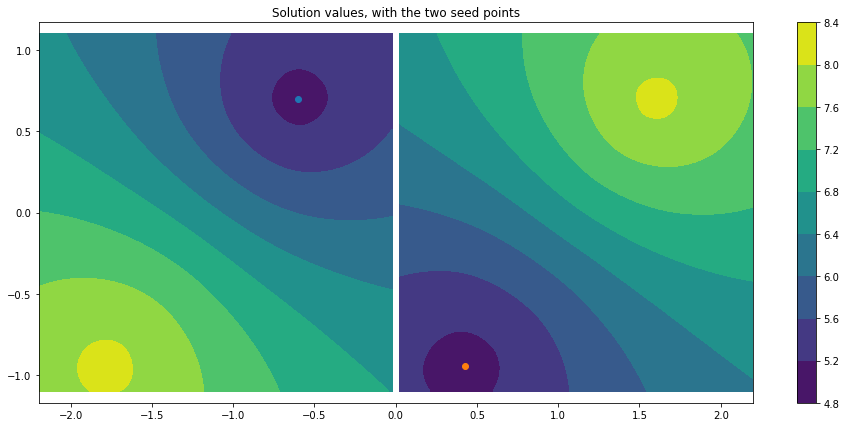

In [126]:
plt.figure(figsize=(16,7))
plt.title('Solution values, with the two seed points')
plt.contourf(*X,hfmOut['values'])
plt.axis('equal'); 
plt.colorbar();
plt.scatter(*hfmIn['seed'])
plt.scatter(*chart_mapping(hfmIn['seed']));

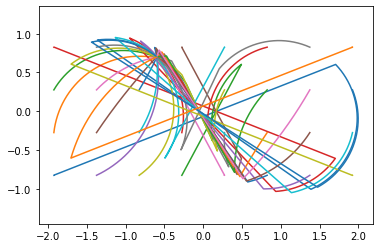

In [127]:
plt.axis('equal')
for geo in hfmOut['geodesics']: plt.plot(*geo)

### 2.3 Comparison with the exact solution

In [130]:
def to_sphere(x):
    x=x.copy()
    s=np.sign(x[0])
    x[0]-=r*s
    return plane_to_sphere(x)*s
    
exact = spherical_distance(to_sphere(X),to_sphere(hfmIn['seed']))

In [132]:
error = hfmOut['values']-exact
assert norm(np.where(error<np.inf,error,0),ord=np.inf) < 0.04 # Errors are quite small

AssertionError: 

### 3. Circular band

We implement periodicity along one axis, independently of the other axis, using a broadcasted mapping.

In [170]:
r=1.1
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seed':[0,0],
    'exportValues':True,
    'cost':1,
})
hfmIn.SetRect([[-1,1],[-r,r]],dimx=100)
hfmIn.SetUniformTips((4,4))
_,aY = hfmIn.Axes()
hfmIn['chart_mapping'] = np.where(aY>0,aY-2,aY+2)
hfmIn['chart_jump'] = np.abs(aY)> (1+r)/2

In [171]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel


ValueError: operands could not be broadcast together with shapes (110,), (2,), (110,)